$~$

# IT Academy - Data Science Itinerary



$~$

## S9 T2: Regression Models
___


In [2]:
#importing libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

sns.set_context("talk")
plt.style.use('ggplot')


$~$
___
#### preprocesing the data:

$~$

$~$

+ As we do [before](https://github.com/Pevicsanch/train_test_sklearn) we are going to download the [dataset](https://www.kaggle.com/datasets/giovamata/airlinedelaycauses) from Kaggle and pre processing it.

$~$

+ let's remember, this dataset is composd by the following variables:


   1. **Year** = 2008
   2. **Month** = 1-12
   3. **DayofMonth** = 1-31
   4.	**DayOfWeek** = 1 (Monday) - 7 (Sunday)
   5.	**DepTime** = actual departure time (local, hhmm)
   6.	**CRSDepTime** = scheduled departure time (local, hhmm)
   7.	**ArrTime** = actual arrival time (local, hhmm)
   8.	**CRSArrTime** = scheduled arrival time (local, hhmm)
   9.	**UniqueCarrier** = unique carrier code
   10.	**FlightNum** = flight number
   11.	**TailNum** = plane tail number: aircraft registration, unique aircraft identifier
   12.	**ActualElapsedTime** = in minutes
   13.	**CRSElapsedTime** = in minutes
   14.	**AirTime** = in minutes
   15.	**ArrDelay** = arrival delay, in minutes: A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).
   16.	**DepDelay** = departure delay, in minutes
   17.	**Origin** = origin IATA airport code
   18.	**Dest** = destination IATA airport code
   19.	**Distance** = in miles
   20.	**TaxiIn** = taxi in time, in minutes
   21.	**TaxiOut** = taxi out time in minutes
   22.	**Cancelled** = *was the flight cancelled
   23.	**CancellationCode** = reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
   24.	**Diverted** = 1 = yes, 0 = no
   25.	**CarrierDelay** = in minutes: Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
   26.	**WeatherDelay** = in minutes: Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
   27.	**NASDelay**  = in minutes: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.
   28.	**SecurityDelay** = in minutes: Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
   29.	**LateAircraftDelay** = in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.

   $~$


In [3]:
PATH = "./data"
#downloanding the data set:
if not os.path.exists(PATH):
    os.makedirs(PATH)
if not os.listdir(PATH):
    !kaggle datasets download -d "giovamata/airlinedelaycauses" --unzip  -p $PATH  

# check the files:
files = [os.path.join(PATH, f) for f in os.listdir(PATH)]
for f in files:
    print(f)

# load the dataset into a pandas dataframe:
df = pd.read_csv(files[3], index_col=[0])


./data/st99_d00.shp
./data/st99_d00.shx
./data/st99_d00.dbf
./data/DelayedFlights.csv


$~$

+ About the pre-processing process:

    +  Since our target variable will be **"ArrDelay"** (*for this exercise we specifically propose to know which flights arrived delayed ( or not) and analyze what variables influence it*), the first thing to keep in mind is that if a flight has been canceled it is impossible for it to reach its destination, so we will not consider those flights for our analysis on delay.

    +  Morever when **"Arrival Delay"** is longer than 15 minutes there's data about what caused the delay. Arrival Delay is the sum of CarrierDelay, WeatherDelay, NASDelay and LateAircraftDelay.

    +  As our target variable is "ArrDelay" it also makes no sense to leave the variable "Security Delay" as it only has values when there is a delay. So, we are able to drop this variable too
    
    + Notice that our target variable (ArrDelay) has negative values . For this exercise, we will consider these values (values equal to or less than zero) as an indicate for those flights arrived on time.

    + "Year", which only has a value of "2018", does not make sense to keep within our set of independent variables.

    +  we are going to change type from "int64" and "object" to "categorical": 

        + Month, DayofMonth, DayOfWeek, Diverted, and FlightNum: these variables are really categorical, and in the case of month and days, they are ordinal. And for "flight number", although it is a number, it is really a label that is repeated
        
       + Same for Origin,Dest,TailNum, UniqueCarrier,Diverted are categorical
    
    + For the missing values in "TailNum" we are going to delete it. Since if we cannot identify the flight, there is little we can do with those values

    + for the other missing/null values convert the NaN values to the mean



$~$

In [4]:
# keep values cancelled ==1 (flights cancelled) in a diferent dataframe.
df_cancelled = df.loc[df['Cancelled'] == 1]


# New dataframe with out cancelled values
df_analisys = df.loc[df['Cancelled'] == 0].copy()

# As we aren't going to use it, we can drop "Cacelled" and "CancellationCode" columns from our new dataframe
df_analisys.drop(columns=["Cancelled", "CancellationCode"], inplace=True)

# copy variables which described caused of the delay into a diferent dataframe to evaluate multicollinearity
df_cause_delay = df_analisys[[
    "CarrierDelay", "WeatherDelay", "NASDelay", "LateAircraftDelay"]].copy()

# keep non necessary variables in a df_non_necessary_
df_non_necessary = df_analisys[["CarrierDelay",
                                "WeatherDelay", "NASDelay", "LateAircraftDelay"]]

# drop non necessary variables from our df_analisys dataframe
df_analisys.drop(columns=["CarrierDelay", "WeatherDelay",
                 "NASDelay", "LateAircraftDelay"], inplace=True)

df_analisys.drop(columns=["SecurityDelay"], inplace=True)

# where 0 = delayed & 1 = on time
df_analisys['with_delay'] = np.where(df_analisys['ArrDelay'] <= 0, 1, 0)

# drop Year from the set of independent variables.
df_analisys.drop(['Year'], axis=1, inplace=True)



In [5]:
# changing types:
to_change = ["Month", "DayofMonth", "DayOfWeek", "Diverted",
             "FlightNum", "Origin", "Dest", "TailNum", "UniqueCarrier",
             "Diverted"]

for x in to_change:
    df_analisys[x] = df_analisys[x].astype("category")

In [6]:
# check for duplicates
print("duplicated values: ", sum(df_analisys.duplicated()))

# drop duplicates
df_analisys.drop_duplicates(inplace=True)

duplicated values:  2


In [7]:
# check for the Missing values by column:
df_analisys.isnull().sum()


Month                   0
DayofMonth              0
DayOfWeek               0
DepTime                 0
CRSDepTime              0
ArrTime              6477
CRSArrTime              0
UniqueCarrier           0
FlightNum               0
TailNum                 5
ActualElapsedTime    7754
CRSElapsedTime        198
AirTime              7754
ArrDelay             7754
DepDelay                0
Origin                  0
Dest                    0
Distance                0
TaxiIn               6477
TaxiOut                 0
Diverted                0
with_delay              0
dtype: int64

In [8]:
#delete null values in "TailNum"
df_analisys.dropna(subset=['TailNum'], inplace=True)


In [9]:
#filter columns with null values
columns_null= df_analisys.columns[df_analisys.isna().any()].tolist()

In [10]:
#imputing missing data, convert the NaN values to the mean.

imp = SimpleImputer (missing_values=np.nan, strategy="mean")
imp.fit(df_analisys[columns_null])
df_analisys[columns_null] = imp.transform(df_analisys[columns_null])

In [11]:
print(df_analisys.isnull().sum())


Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Diverted             0
with_delay           0
dtype: int64


$~$

As the dataset is large, we are going to perform a sampling of 1% the dataset

$~$

In [12]:
#performing a sample 
df_analisys_sample = df_analisys.sample(frac=0.01, random_state=42)

#cleaning the memory
del df_analisys

In [13]:
# dependent variables
y = df_analisys_sample[["ArrDelay"]]

# independent variables
X = df_analisys_sample.drop(["ArrDelay", "with_delay"], axis=1)


In [14]:
#filter categorical variables
X_cat = X.select_dtypes(include=["category"])

#"Month","DayofMonth","DayOfWeek" are already label
X_label= X_cat[["Month","DayofMonth","DayOfWeek"]]

X_cat = X_cat.drop (["Month","DayofMonth","DayOfWeek"], axis=1)

#filter numerical variables

X_num= X.select_dtypes(include=["int64","float64"])

#encoding dummy variables
coder = OneHotEncoder(handle_unknown="ignore",drop='if_binary') #drop binary to avoid multicollinarity 
result = coder.fit_transform(X_cat)
X_cat_encoder = pd.DataFrame.sparse.from_spmatrix(result)
X_cat_encoder.columns = coder.get_feature_names_out()


In [15]:
#prepare the explanatory variable
X_label_ =  X_label.reset_index(drop=True)
X_num_ = X_num.reset_index(drop=True)
X_cat_encoder = X_cat_encoder.reset_index(drop=True)

frames = [X_label_, X_cat_encoder, X_num_]


X = pd.concat(frames, axis=1)



$~$

+ check if our independent variables present multicollinearity:

$~$

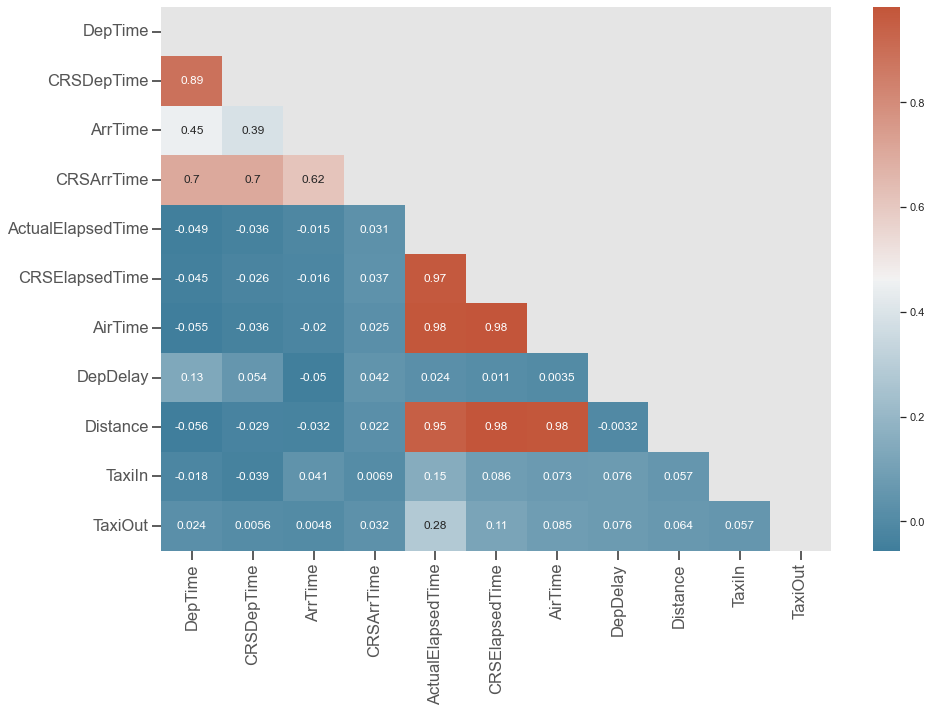

In [16]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(15, 10))
corr = X_num.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)
plt.show()


$~$
___
####  Exercise 1

$~$

Create at least three different regression models to try to predict DelayedFlights.csv's flight delay (ArrDelay) as best you can. 

$~$
___

$~$

We are going to performace 3 regressions:

+   Linear regression (using numeric features)
+   Ridge regression (using all features)
+   Lasso regression (using all features)

$~$

##### Linear regression

$~$

+ as the first task, let's performing a linear regression  using numeric features

$~$


In [17]:
#creating feature and target arrays

# X_reg = X_num.values
# y_reg = y["ArrDelay"].values


# # Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_num_,
y, test_size = 0.3, random_state=42)

#  # Create the regressor: reg_all
reg_all = LinearRegression()

# # Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# # Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# # Compute and print R^2 and RMSE
r2_reg = reg_all.score(X_test, y_test)
print("R^2: {}".format(r2_reg))

rmse_reg = np.sqrt(mean_squared_error(y_test,y_pred))

print("Root Mean Squared Error: {}".format(rmse_reg))


R^2: 0.9827848567809067
Root Mean Squared Error: 7.481332662040825


The predictions of the final model are on average 7.48 min away from the real value.

$~$


##### Ridge regression: Regression with all features

$~$

+  let's try using all features

$~$

In [18]:
# Create training and test sets
# X_ridge = X.values
# y_ridge = y["ArrDelay"].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size = 0.3, random_state=42)

# Create the regressor: ridge
ridge =Ridge()

# Fit the regressor to the training data
ridge.fit(X_train,y_train)

# # Predict on the test data: y_pred
y_pred = ridge.predict(X_test)

# # Compute and print R^2 and RMSE
r2_ridge = ridge.score(X_test, y_test)
print("R^2: {}".format(r2_ridge))
rmse_ridge = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse_ridge))

R^2: 0.9736701121574977
Root Mean Squared Error: 9.2522668679228


The predictions of the final model are on average 9.25 min away from the real value.

$~$



#####  Lassso Regression: Regression with all features

$~$

+  let's try using all features, and check how many features will the model select to use

$~$

In [19]:
# Create training and test sets
# X_lasso = X.values
# y_lasso = y["ArrDelay"].values

X_train, X_test, y_train, y_test = train_test_split(X_num, y,
test_size = 0.3, random_state=42)

# Create the regressor: lasso
lasso =Lasso()

# Fit the regressor to the training data
lasso.fit(X_train,y_train)

# # Predict on the test data: y_pred
y_pred = lasso.predict(X_test)

# # Compute and print R^2 and RMSE
r2_lasso = lasso.score(X_test, y_test)
print("R^2: {}".format(r2_lasso))

rmse_lasso = np.sqrt(mean_squared_error(y_test,y_pred))

print("Root Mean Squared Error: {}".format(rmse_lasso))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))


R^2: 0.9827777098609054
Root Mean Squared Error: 7.482885450103868
Number of features used: 11


The predictions of the final model are on average 7.48 min away from the real value. In addition, the number of variables chosen by the model coincides with the number of variables that we use in the linear regression model (11 features).

$~$


$~$
___
####  Exercise 2

$~$

Compare them based on MSE and R2.

$~$
___

In [20]:
# assign data of lists.  
data = {'R^2':[r2_reg,r2_ridge,r2_lasso], 'RMSE':[rmse_reg,rmse_ridge,rmse_lasso]}  
  
# Creates pandas DataFrame.  
df = pd.DataFrame(data, index =['Linear_regression', 'Ridge_regression', 'Lasso_regression'])  
  
# print the dataframe
df


,R^2,RMSE
Linear_regression,0.982785,7.481333
Ridge_regression,0.973670,9.252267
Lasso_regression,0.982778,7.482885


$~$

 + In the table below shows:
 
    + The  score of Ridge regression is lower than for LinearRegression. This is consistent with our expectation. With linear regression, we were overfitting our data. Ridge is a more restricted model, so we are less likely to overfit. 

    + Lasso regression not only selects the most significant variables (in this case 11 and that coincide with the number of variables of the linear regression) it also gives us values close to those of the linear regression
$~$

$~$
___
####  Exercise 3

$~$

Train them using the different parameters they support.

$~$
___

$~$

Although it is possible to optimize the hyperparameters of the models using Random Search and Grid Search, for this exercise we will use only Grid search.

$~$


$~$

+ Linear regression: 

$~$


Even though the linear regression model does not have hyperparameters that can be tuned. Let's try using Gridsearch to fit some atributes of the model values:

$~$


In [21]:
# # Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_num_, y,
    test_size=0.3,random_state =42 )

# Setup the hyperparameter grid
parameters = {'fit_intercept':[True,False], 'normalize':[True,False],
 'copy_X':[True, False], "positive": [True,False]}
# Instantiate a linear regression:
reg_all = LinearRegression()

#instantiate the GridSearchCV object: reg_grid

reg_grid = GridSearchCV(reg_all,parameters, cv=3)

# Fit it to the data

reg_grid.fit(X_train,y_train)

# # Predict on the test data: y_pred
y_pred = reg_grid.predict(X_test)



# Print the tuned parameters and score

print("Tuned lineal Regression Parameters: {}".format(reg_grid.best_params_)) 

r2_reg_grid = reg_grid.best_score_

print("Best score is {}".format(r2_reg_grid))

rmse_reg_grid = np.sqrt(mean_squared_error(y_test,y_pred))

print("Root Mean Squared Error: {}".format(rmse_reg))


Tuned lineal Regression Parameters: {'copy_X': True, 'fit_intercept': True, 'normalize': True, 'positive': False}
Best score is 0.9796286966783908
Root Mean Squared Error: 7.481332662040825


$~$

+ ridge regression: 

$~$

We are going to use Gridsearch to find the best alpha parameter for the model

In [22]:
# # Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size = 0.3, random_state=42)

# Setup the hyperparameter grid

params_Ridge = {'alpha': [1,0.1,0.01,0] }

# Create the regressor: ridge
ridge =Ridge()

#instantiate the GridSearchCV object: rigde_grid

rigde_grid = GridSearchCV(ridge,params_Ridge, cv=3)
# Fit it to the data

rigde_grid.fit(X_train,y_train)


# # Predict on the test data: y_pred
y_pred = rigde_grid.predict(X_test)


# Print the tuned parameters and score
print("Tuned lineal Regression Parameters: {}".format(rigde_grid.best_params_)) 

r2_ridge_grid = rigde_grid.best_score_

print("Best score is {}".format(r2_ridge_grid))

rmse_rigde_grid = np.sqrt(mean_squared_error(y_test,y_pred))

print("Root Mean Squared Error: {}".format(rmse_rigde_grid))


Tuned lineal Regression Parameters: {'alpha': 1}
Best score is 0.9762650824872631
Root Mean Squared Error: 9.2522668679228


$~$

+ Lasso regression: 

$~$

We are going to use Gridsearch to find the best alpha parameter for the model

In [23]:
# # Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size = 0.3, random_state=42)
# Setup the hyperparameter grid

params = {'alpha': [1,0.1,0.01,0]}
lasso = Lasso()

# instantiate the GridSearchCV object: lasso_grid

lasso_grid = GridSearchCV(lasso, params, cv = 3)

# Fit it to the data
lasso_grid.fit(X_train, y_train)

# # Predict on the test data: y_pred
y_pred = lasso_grid.predict(X_test)


# Print the tuned parameters and score
print("Tuned lineal Regression Parameters: {}".format(lasso_grid.best_params_)) 

r2_lasso_grid = lasso_grid.best_score_
print("Best score is {}".format(r2_lasso_grid))

rmse_lasso_grid = np.sqrt(mean_squared_error(y_test,y_pred))

print("Root Mean Squared Error: {}".format(rmse_lasso_grid))


Tuned lineal Regression Parameters: {'alpha': 1}
Best score is 0.9796894226109717
Root Mean Squared Error: 7.482885325672634


$~$
___
####  Exercise 4

$~$

Compare your performance using the train / test approach or using all data (internal validation)

$~$
___

$~$

Let's try our models using Cross validation:

$~$


+ linear regression:

In [26]:
# Create a linear regression object: reg

reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X_num_,y,cv=5) 

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.99442803 0.97181074 0.97888641 0.97393024 0.98506255]
Average 5-Fold CV Score: 0.9808235943683543


+ ridge regression:

In [27]:
# Instantiate a ridge regressor: ridge
ridge = Ridge()

# Perform -fold cross-validation: ridge_cv
ridge_cv = cross_val_score(ridge,X,y,cv=5)

# Print the cross-validated scores
print(ridge_cv)

print("Average 5-Fold CV Score: {}".format(np.mean(ridge_cv)))

[0.98826807 0.96951569 0.97489098 0.96723647 0.9781799 ]
Average 5-Fold CV Score: 0.9756182219538576


+ lasso regression:

In [28]:
# Instantiate a lasso regressor: lasso
lasso = Lasso()

# Perform 5-fold cross-validation: lasso_cv
lasso_cv = cross_val_score(lasso,X,y,cv=5)

# Print the cross-validated scores
print(lasso_cv)

print("Average 5-Fold CV Score: {}".format(np.mean(lasso_cv)))

[0.99441804 0.97190085 0.97882321 0.97388444 0.98504906]
Average 5-Fold CV Score: 0.9808151201402062


$~$
___
####  Exercise 5

$~$

Perform some variable engineering process to improve prediction

$~$
___

$~$

in order to improve the model we are going to normalize the numerical variables (we are going to use [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) 
$~$


+ linear regression:

In [29]:
#copy_X': True, 'fit_intercept': True, 'normalize': True, 'positive': False

# Setup the pipeline steps: steps
steps = [ ("normalizer", MinMaxScaler()),
            ("reg", LinearRegression(normalize=False,copy_X=True,fit_intercept=True,positive=False))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the parameters space
parameters = {'fit_intercept':[True,False]}

 # Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_num_, y,
    test_size=0.3,random_state =42)

# Fit the pipeline to the training set

reg_norm = pipeline.fit(X_train,y_train)

# # Predict on the test data: y_pred
y_pred = reg_norm.predict(X_test)

# Compute and print the metrics
r2_reg_norm = reg_norm.score(X_test, y_test)
rmse_reg_nom = np.sqrt(mean_squared_error(y_test,y_pred))


print("Tuned lineal regression R squared: {}".format(r2_reg_norm))
print("Root Mean Squared Error: {}".format(rmse_reg_nom))





Tuned lineal regression R squared: 0.9827848567809067
Root Mean Squared Error: 7.4813326620408365


+ ridge regression:

In [30]:
# Setup the pipeline steps: steps
steps = [ ("normalizer", MinMaxScaler()),
            ("ridge", Ridge(normalize=False,solver="saga",max_iter=2,positive=False,))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set

ridge_norm = pipeline.fit(X_train,y_train)

# # Predict on the test data: y_pred
y_pred = ridge_norm.predict(X_test)

# Compute and print the metrics
r2_ridge_norm= ridge_norm.score(X_test, y_test)
print("Tuned Ridge R squared: {}".format(r2_ridge_norm))
rmse_ridge_norm = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse_ridge_norm))





Tuned Ridge R squared: 0.9673314208639724
Root Mean Squared Error: 10.305967516818944


+ lasso regression:

In [31]:
# Setup the pipeline steps: steps
steps = [ ("normalizer", MinMaxScaler()),
            ("lasso", Lasso(warm_start=True,normalize=False, positive=True,fit_intercept=True))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set

lasso_norm = pipeline.fit(X_train,y_train)

# # Predict on the test data: y_pred
y_pred = lasso_norm.predict(X_test)

# Compute and print the metrics
r2_lasso_norm= lasso_norm.score(X_test, y_test)
print("Tuned lasso R squared: {}".format(r2_lasso_norm))
rmse_lasso_norm = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse_lasso_norm))






Tuned lasso R squared: 0.7890651197160649
Root Mean Squared Error: 26.18772952163165


$~$
___
####  Exercise 6

$~$

Do not use the DepDelay variable when making predictions


$~$
___

In [32]:
#drop DepDelay 
X = X.drop(["DepDelay"],axis=1)
X_num = X_num.drop(["DepDelay"], axis=1)


+ linear regression:

In [33]:
#creating feature and target arrays without "DepDelay"

# X_reg = X_num.values
# y_reg = y["ArrDelay"].values

# Setup the pipeline steps: steps
steps = [ ("normalizer", MinMaxScaler()),
            ("reg", LinearRegression(copy_X= True, fit_intercept= True))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)


 # Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_num, y,
    test_size=0.3,random_state =42 )

# Fit the pipeline to the training set

reg_norm_without = pipeline.fit(X_train,y_train)

# # Predict on the test data: y_pred
y_pred = reg_norm_without.predict(X_test)

# Compute and print the metrics
r2_reg_norm_without = reg_norm_without.score(X_test, y_test)
rmse_reg_nom_without = np.sqrt(mean_squared_error(y_test,y_pred))


print("Tuned lineal regression R squared: {}".format(r2_reg_norm_without))
print("Root Mean Squared Error: {}".format(rmse_reg_nom_without))



Tuned lineal regression R squared: 0.1425497342553621
Root Mean Squared Error: 52.79929405798076


+ ridge regression:

In [36]:
#creating feature and target arrays without "DepDelay"

# X_ridge = X
# y_ridge = y["ArrDelay"].values

# Setup the pipeline steps: steps
steps = [ ("normalizer", MinMaxScaler()),
            ("ridge", Ridge(normalize=False,solver="saga",max_iter=2,positive=False,))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)


 # Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.3,random_state =42 )

# Fit the pipeline to the training set

ridge_norm_without = pipeline.fit(X_train,y_train)

# # Predict on the test data: y_pred
y_pred = ridge_norm_without.predict(X_test)

# Compute and print the metrics
r2_ridge_norm_without = ridge_norm_without.score(X_test, y_test)
rmse_ridge_nom_without = np.sqrt(mean_squared_error(y_test,y_pred))


print("Tuned lineal regression R squared: {}".format(r2_ridge_norm_without))
print("Root Mean Squared Error: {}".format(rmse_ridge_nom_without))



Tuned lineal regression R squared: 0.044352154863894544
Root Mean Squared Error: 55.74072186678194


+ lasso regression:

In [37]:
#creating feature and target arrays without "DepDelay"

# X_lasso = X
# y_lasso = y["ArrDelay"].values

# Setup the pipeline steps: steps
steps = [("normalizer", MinMaxScaler()),
("y_lasso", Lasso(alpha=1, fit_intercept=True))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)


 # Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state =42 )

# Fit the pipeline to the training set

y_lasso_norm_without = pipeline.fit(X_train,y_train)

# # Predict on the test data: y_pred
y_pred = y_lasso_norm_without.predict(X_test)

# Compute and print the metrics
r2_y_lasso_norm_without = y_lasso_norm_without.score(X_test, y_test)
rmse_y_lasso_nom_without = np.sqrt(mean_squared_error(y_test,y_pred))


print("Tuned lineal regression R squared: {}".format(r2_y_lasso_norm_without))
print("Root Mean Squared Error: {}".format(rmse_y_lasso_nom_without))




Tuned lineal regression R squared: 0.012177624620871574
Root Mean Squared Error: 56.671287047222044



#### Compare all MSE and R2.


In [38]:
# assign data of lists.
data = {'R^2': [r2_reg, r2_ridge, r2_lasso, r2_reg_grid, r2_ridge_grid,
                r2_lasso_grid, r2_reg_norm, r2_ridge_norm, r2_lasso_norm,r2_reg_norm_without,
                r2_ridge_norm_without,r2_y_lasso_norm_without],
        'RMSE': [rmse_reg, rmse_ridge, rmse_lasso, rmse_reg_grid, rmse_rigde_grid,
                 rmse_lasso_grid, rmse_reg_nom, rmse_ridge_norm, rmse_lasso_norm,rmse_reg_nom_without,
                 rmse_ridge_nom_without,rmse_y_lasso_nom_without]}

# Creates pandas DataFrame
df = pd.DataFrame(data, index=['Linear_regression',
                               'Ridge_regression', 'Lasso_regression', "Linear_regression_gridsearch",
                               "Ridge_regression_gridsearch", "Lasso_regression_gridsearch", "Linear_regression_normalized", 
                               "Ridge_regression_normalized", "Lasso_regression_normalized","Linear_regression_non_Depdelay",
                               "Ridge_regression__non_Depdelay","Lasso_regression__non_Depdelay"])

# print the dataframe
df


,R^2,RMSE
Linear_regression,0.982785,7.481333
Ridge_regression,0.973670,9.252267
Lasso_regression,0.982778,7.482885
Linear_regression_gridsearch,0.979629,7.481333
Ridge_regression_gridsearch,0.976265,9.252267
Lasso_regression_gridsearch,0.979689,7.482885
Linear_regression_normalized,0.982785,7.481333
Ridge_regression_normalized,0.967331,10.305968
Lasso_regression_normalized,0.789065,26.187730
Linear_regression_non_Depdelay,0.142550,52.799294


$~$
___
####  Conclusions

$~$

+ Some considerations about the size of the data:

    + to generate the models, I had to take a sample of 1% of the data. Despite this, the execution time of the models has been quite high. to generate the models, I had to take a sample of 1% of the data. Despite this, the execution time of the models has been quite high. Especially for the execution of the Gridsearch. where I have only been able to find the best alpha, when there are certainly other hyperparameters that could be improved

+ This can be seen in all the models we have generated. The linear regression model may, due to the scores, be better, however, it must be taken into account how general it is. In fact, this is the reason why for the linear regression model I have used only the numerical variables. If we compare the scores of the linear regression (which only receives numerical variables) with the other two regressions, we see that the scores are relatively close. This, in other words, shows us that the algorithm of the ridge and lasso regressions discriminate the insignificant independent variables.

+ In the case with Cross Validation, there is no improvement with respect to the models, so we can say that the models could be improved and that the first models have a bias to improve.

+ To improve the models we can adjust the hyperparameters. we could have chosen between grind-search or random-search to do it. I chose grind-search, knowing that this method has a very high computational cost. Precisely to test my computer. In this case I have only evaluated the alpha value in the models, however, there are many more hyperameters that can be evaluated.

+ Since there are outliers in the dataframe, I have chosen to normalize the data using the MinMaxScaler method. 

    +   it performance doesn't affect the lineal regression model.
    +  however, the normalization process does affect the lasso and ridge models. Lasso regression puts constraints on the size of the coefficients associated to each variable. However, this value will depend on the magnitude of each variable. The result of centering the variables means that there is no longer an intercept. This applies equally to ridge regression.


+ After removing the variable "DepDelay", the results show that this variable is very important to explain ArrDelay. This is verified in the low results of the models.


+ finally, finally we can understand that in lasso regression, algorithm is trying to remove the extra features that doesn't have any use which sounds better because we can train with less data very nicely as well but the processing is a little bit harder, but in ridge regression the algorithm is trying to make those extra features less effective but not removing them completely which is easier to process. 




___
$~$

___
$~$

####  *References*:

+ [methods for classification & regression](https://www.educative.io/blog/scikit-learn-cheat-sheet-classification-regression-methods) 
+ [Hyperparameter Optimization With Random Search and Grid Search](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/) 
+ []() 
$~$
___